# Preface

In this notebook, we build a simple CNN to classify chest x-ray images into two categories, NORMAL or PNEUMONIA. In so doing, we also introduce a practically useful image data processing pipeline based on `ImageDataGenerator` in `keras`.

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
sns.set(font_scale=1.5, style='dark')
np.random.seed(123)

# Downloading Dataset from Kaggle

We will download the chest x-ray image directly from Kaggle. We will use the [kaggle API](https://github.com/Kaggle/kaggle-api).

Alternatively, you can also download the data manually from [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

In [11]:
import kaggle
kaggle.api.authenticate()

#kaggle.api.dataset_download_files(
#    'paultimothymooney/chest-xray-pneumonia',
#    path='./data',
#    quiet=False,
#    unzip=True,
#    force=False,
#)

We will look at some images. We will use the `load_img` function from `keras.preprocessing` module, which uses `PIL`.

In [12]:
from tensorflow.keras.preprocessing.image import load_img

In [13]:
data_dir = pathlib.Path('./data/chest_xray')
train_dir = data_dir.joinpath('train')
val_dir = data_dir.joinpath('val')
test_dir = data_dir.joinpath('test')

We compare some normal and pneumonia images.

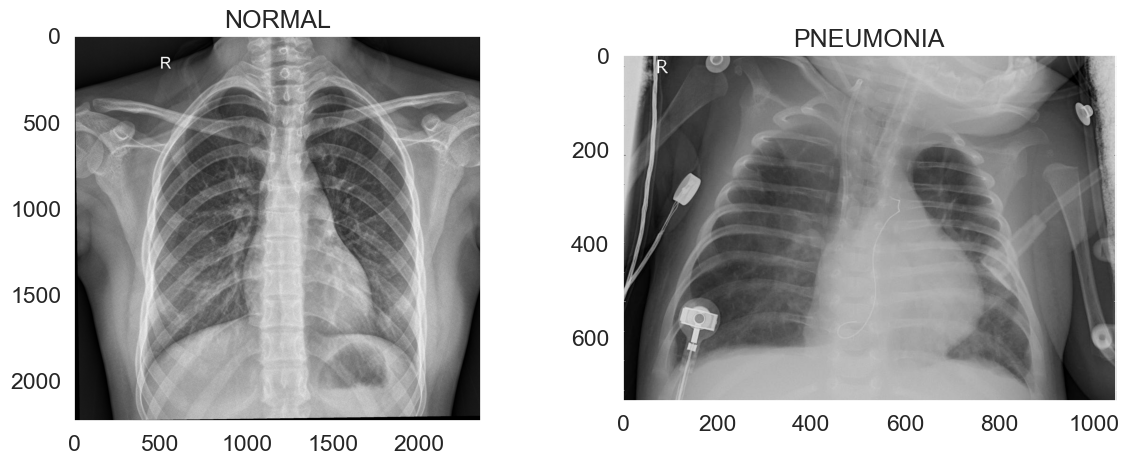

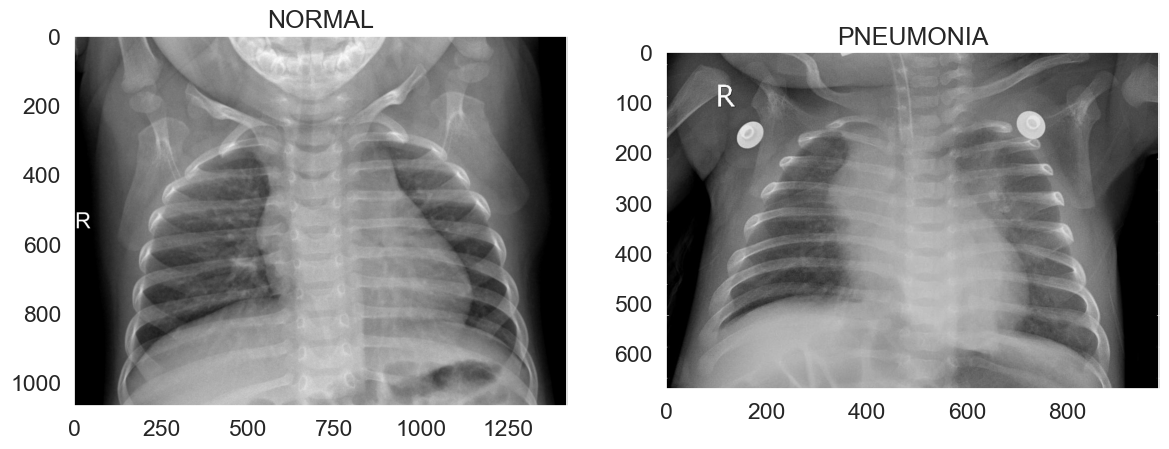

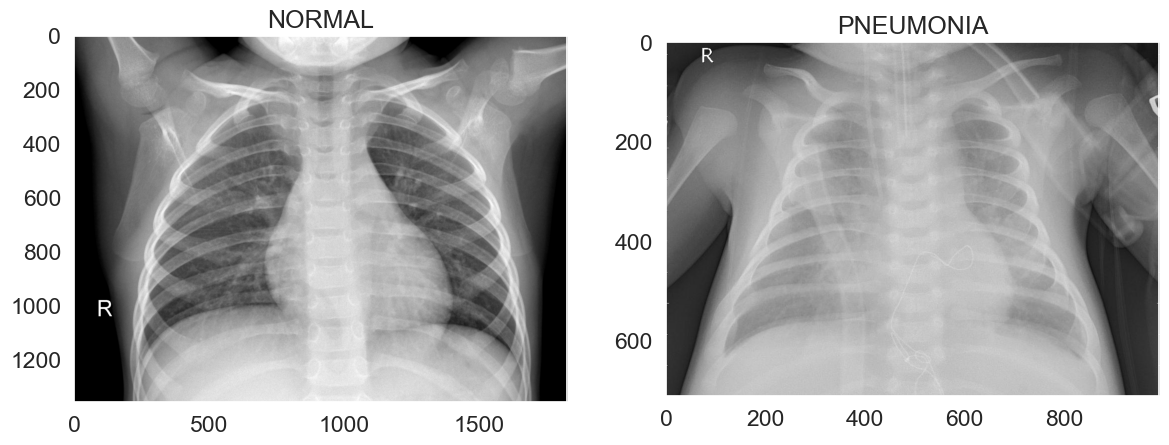

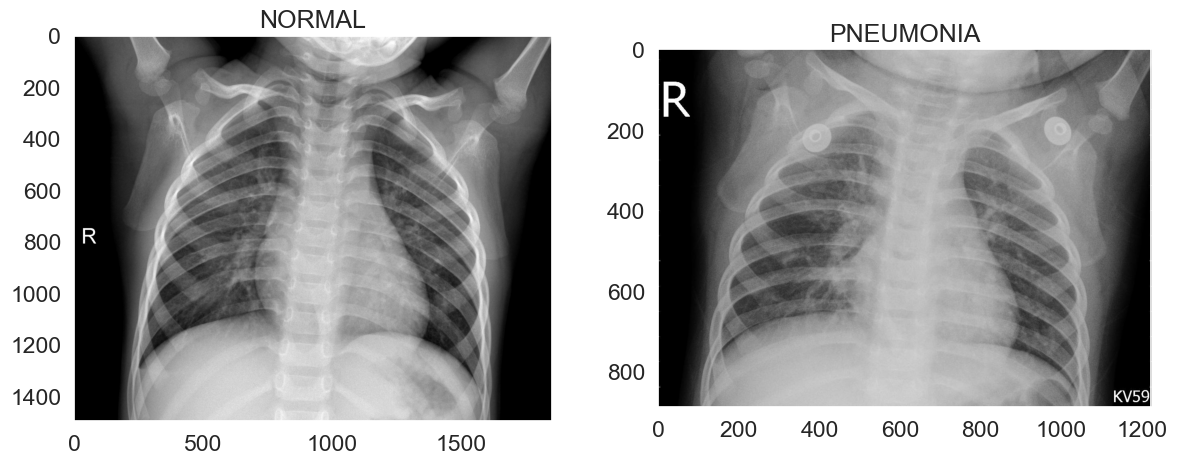

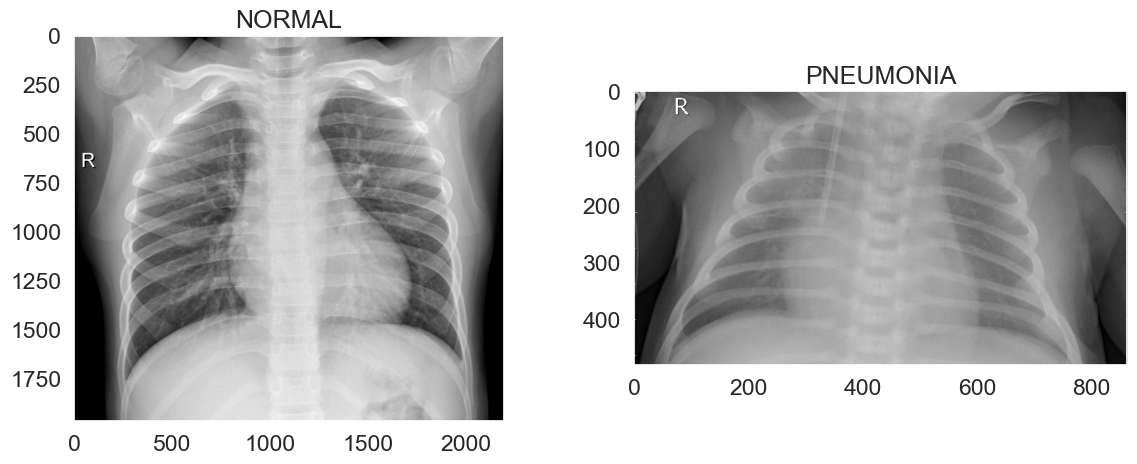

In [14]:
for i in range(5):
    normal_image = load_img(list(train_dir.glob('NORMAL/*'))[i])
    pneumonia_image = load_img(list(train_dir.glob('PNEUMONIA/*'))[i])
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.imshow(normal_image)
    ax1.set_title('NORMAL')
    ax2.imshow(pneumonia_image)
    ax2.set_title('PNEUMONIA')

 To the untrained eye, it is not always straight-forward to tell which is which. Let us now build a CNN model to classify these images into NORMAL vs PNEUMONIA.

# Building A Simple CNN for Pneumonia Classification

## Image Processing Pipeline

Before building a model, let us take a look at the input data shapes and scales.

In [15]:
for i in range(5):
    normal_image = np.array(load_img(list(train_dir.glob('NORMAL/*'))[i]))
    print(f'Shape: {normal_image.shape}, Min: {normal_image.min()}, Max: {normal_image.max()}')    

Shape: (2234, 2359, 3), Min: 0, Max: 255
Shape: (1067, 1422, 3), Min: 0, Max: 255
Shape: (1357, 1828, 3), Min: 0, Max: 255
Shape: (1495, 1854, 3), Min: 0, Max: 255
Shape: (1966, 2194, 3), Min: 0, Max: 255


Of course, the images will require normalization. Moreover, the image sizes are huge ($\mathcal{O}(10^8)$ pixels) so there should be some preprocessing done. 

The dataset size is non-trivial (~2.5G) so it is not very efficient to load everything into memory. Instead, we can try to load the data on-the-fly during training. 

Both of these can be achieved by the `ImageDataGenerator` class found in `tensorflow.keras.preprocessing.image`. We will use its bare-basic functionalities for now and gradually expand on it in later lectures.

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
data_generator = ImageDataGenerator(rescale=1./255)

In [18]:
img_size = (128, 128)
batch_size = 16

The `flow_from_directory` method allows on-the-fly loading and training from the directory, without the need to load in memory. This will be faster if you are using a SSD.

In [19]:
train_gen = data_generator.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary')

val_gen = data_generator.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary')

test_gen = data_generator.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Build CNN Model

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3),activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Metal device set to: Apple M2


2023-02-04 13:04:17.968332: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-04 13:04:17.968434: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

## Train CNN

In [24]:
from tqdm.keras import TqdmCallback

Since we are now working with data generators, we will need to find out how many data points are there.

In [25]:
num_train = len(list(train_dir.glob('./*/*')))
num_val = len(list(val_dir.glob('./*/*')))
num_test = len(list(test_dir.glob('./*/*')))
print(f'Num train: {num_train} Num val: {num_val} Num test: {num_test}')

Num train: 5216 Num val: 16 Num test: 624


In [26]:
model_save_dir = pathlib.Path('cnn_pneumonia_weights.h5')

In [27]:
if model_save_dir.exists():
    model.load_weights(str(model_save_dir))
else:
    history = model.fit(
        train_gen,  # Instead of providing (x_train, y_train), we will use the generator constructed before
        steps_per_epoch=num_train // batch_size,  # This is required for data generator feeding
        epochs=10,
        validation_data=val_gen,
        validation_steps=num_val // batch_size,
        verbose=0,
        callbacks=[TqdmCallback(verbose=1)],
        workers=8,
    )
    model.save_weights(str(model_save_dir))
    results = pd.DataFrame(history.history)
    results['epoch'] = history.epoch

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

2023-02-04 13:04:18.946244: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-04 13:04:19.420778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-04 13:04:42.750685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


## Evaluate the Model

Accuracy can be obtained from `evaluate`.

In [28]:
loss, acc = model.evaluate(test_gen, workers=8, verbose=0)
print(f'Loss: {loss}  Accuracy: {acc}')

Loss: 1.2287808656692505  Accuracy: 0.7740384936332703


We can also look at the precision/recall and the confusion matrix.

In [29]:
from sklearn.metrics import confusion_matrix, classification_report

In [30]:
y_pred = model.predict(test_gen)
y_pred = 1 * (y_pred.squeeze() > 0.5)
y_true = test_gen.classes

print(classification_report(y_true, y_pred))

2023-02-04 14:13:00.010485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


39/39 [==============================] - 4s 91ms/step
              precision    recall  f1-score   support

           0       0.97      0.41      0.58       234
           1       0.74      0.99      0.85       390

    accuracy                           0.77       624
   macro avg       0.85      0.70      0.71       624
weighted avg       0.82      0.77      0.74       624



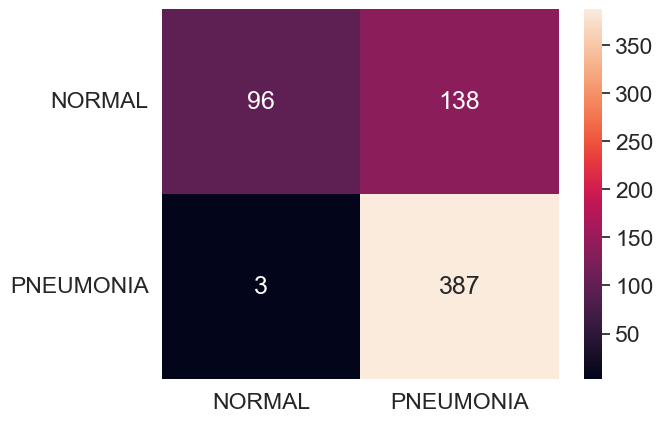

In [31]:
cmatrix = confusion_matrix(y_true, y_pred)

ax = sns.heatmap(cmatrix, annot=True, fmt="d")
ax.set_xticklabels(['NORMAL', 'PNEUMONIA'])
ax.set_yticklabels(['NORMAL', 'PNEUMONIA'], rotation=0);

# Exercise

Tweak the network and/or training procedure to improve performance. In this course we will introduce a number of such techniques along the way.